# Note: Maps only visible when notebook is opened in "trusted mode"

In [1]:
from pyspark import SparkContext, SparkConf
cf = SparkConf()
cf.set("spark.submit.deployMode","client")
sc = SparkContext.getOrCreate(cf)
from pyspark.sql import SparkSession
spark = SparkSession \
	    .builder \
	    .appName("Python Spark SQL") \
	    .config("spark.some.config.option", "some-value") \
	    .getOrCreate()
                            

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/09 02:14:04 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/09 02:14:04 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/09 02:14:04 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/05/09 02:14:04 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [2]:
!pip install dataframe_image
import pyspark.sql.functions as F
from pyspark.sql.types import StructField, StructType, StringType, TimestampType, DateType
from pyspark.sql import Window
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import dataframe_image as dfi
import folium
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.ops import unary_union
from branca.colormap import LinearColormap, StepColormap


Defaulting to user installation because normal site-packages is not writeable


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


In [3]:
data = spark.read.csv(path='/shared/TransitTrends/MTA_CLEAN/daily_counts.csv', header=True, inferSchema=True)

complex_id_impute = data.filter((F.col('STATION')=='HOWARD BCH JFK') & (F.col('COMPLEX_ID').isNotNull())).select('COMPLEX_ID').distinct().collect()[0][0]

data = data.withColumn("COMPLEX_ID", F.when((data.STATION == "HOWARD BCH JFK"),complex_id_impute) .otherwise(data.COMPLEX_ID))

data = data.filter((F.col('COMPLEX_ID').isNotNull()))

data = data.groupBy(F.col('STATION'), F.col('COMPLEX_ID') , F.col("DATE")).agg(F.sum("ENTRIES").alias('ENTRIES'),F.sum("EXITS").alias('EXITS'))

In [4]:
data.show(5)

+--------+----------+----------+-------+-----+
| STATION|COMPLEX_ID|      DATE|ENTRIES|EXITS|
+--------+----------+----------+-------+-----+
|BURKE AV|     422.0|2021-04-26|   1461|  826|
|BURKE AV|     422.0|2021-11-19|   1846| 1128|
|BURKE AV|     422.0|2022-01-21|   1474|  926|
|BURKE AV|     422.0|2022-04-29|   1724| 1166|
|BURKE AV|     422.0|2022-10-22|    803|  758|
+--------+----------+----------+-------+-----+
only showing top 5 rows



In [5]:
#Show annual entries and exits
data.groupBy(F.year("DATE").alias("Year")).agg(F.sum("ENTRIES").alias("Entries"),F.sum("EXITS").alias("Exits")).show()

+----+----------+----------+
|Year|   Entries|     Exits|
+----+----------+----------+
|2022| 675984582| 955420186|
|2019|1708033002|1352424801|
|2020| 629352464| 576790684|
|2021| 619953878| 704184381|
+----+----------+----------+



# Plotting daily exits and Entries

In [6]:
#find daily exits and save as a regular pandas dataframe to plot the same

daily_exits= data.groupBy("DATE").agg(F.sum("EXITS").alias("Exits"), F.sum("ENTRIES").alias("Entries")).toPandas()

daily_exits['Date'] = pd.to_datetime(daily_exits['DATE'])

daily_exits = daily_exits.sort_values(by='Date')

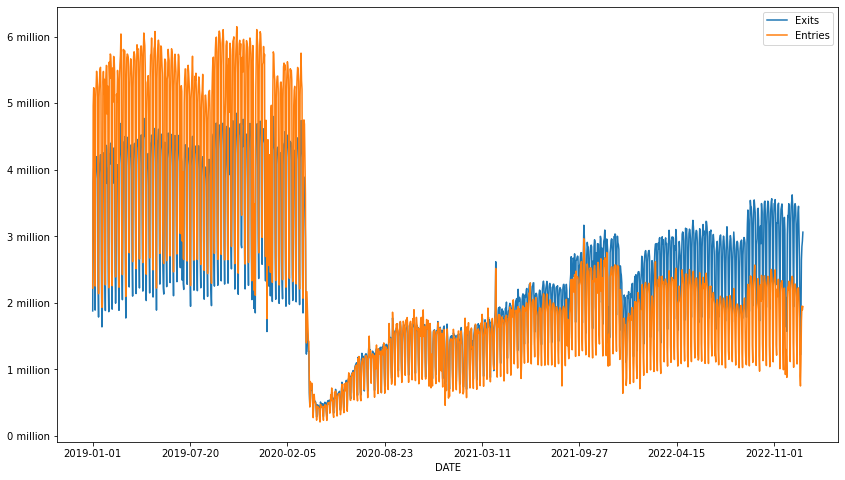

In [7]:
#plot daily exits and save the figure (Saved in the present working directory)
fig, ax = plt.subplots(figsize=(14, 8))
daily_exits.plot.line(x="DATE", y="Exits", ax=ax)
daily_exits.plot.line(x="DATE", y="Entries", ax=ax)

def millions_format(value, tick_number):
    return f'{int(value/1000000)} million'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_format))

plt.savefig('daily_exits_plot.png', dpi=300)

# Top 5 most used stations for each year between 2019-2022

In [8]:
data.filter(F.year("DATE").isin([2019])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).drop("COMPLEX_ID").show(5)

+---------------+--------+
|        STATION|   Exits|
+---------------+--------+
|GRD CNTRL-42 ST|40915102|
|34 ST-HERALD SQ|36862009|
| TIMES SQ-42 ST|30284646|
| 14 ST-UNION SQ|30002388|
|42 ST-PORT AUTH|25952100|
+---------------+--------+
only showing top 5 rows



In [9]:
data.filter(F.year("DATE").isin([2020])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).drop("COMPLEX_ID").show(5)

+---------------+--------+
|        STATION|   Exits|
+---------------+--------+
|34 ST-HERALD SQ|13487659|
|GRD CNTRL-42 ST|12955645|
| 14 ST-UNION SQ|10969076|
|42 ST-PORT AUTH|10006958|
| TIMES SQ-42 ST| 9629722|
+---------------+--------+
only showing top 5 rows



In [10]:
data.filter(F.year("DATE").isin([2021])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).drop("COMPLEX_ID").show(5)

+---------------+--------+
|        STATION|   Exits|
+---------------+--------+
|34 ST-HERALD SQ|15589749|
|GRD CNTRL-42 ST|15096203|
| 14 ST-UNION SQ|13799869|
|42 ST-PORT AUTH|12072012|
| TIMES SQ-42 ST|11619074|
+---------------+--------+
only showing top 5 rows



In [11]:
data.filter(F.year("DATE").isin([2022])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).drop("COMPLEX_ID").show(5)

+---------------+--------+
|        STATION|   Exits|
+---------------+--------+
|GRD CNTRL-42 ST|24467082|
|34 ST-HERALD SQ|22243714|
| TIMES SQ-42 ST|19572419|
| 14 ST-UNION SQ|19276367|
|42 ST-PORT AUTH|16943084|
+---------------+--------+
only showing top 5 rows



# Find %change in ridership relative to 2019 for each station between 2020-2022

In [12]:
#Filter data by year and then convert it to a a Pandas Dataframe to generate visualizations
station_exits_2019=data.filter(F.year("DATE").isin([2019])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).toPandas()
station_exits_2020=data.filter(F.year("DATE").isin([2020])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).toPandas()
station_exits_2021=data.filter(F.year("DATE").isin([2021])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).toPandas()
station_exits_2022=data.filter(F.year("DATE").isin([2022])).groupBy("STATION", "COMPLEX_ID").agg(F.sum("EXITS").alias("Exits")).orderBy("Exits", ascending=False).toPandas()


In [13]:
#Get Lat and Lon of stations
station_locations=spark.read.csv('/shared/TransitTrends/station_locations.csv' ,header=True).toPandas()
station_locations["Complex ID"] = station_locations["Complex ID"].astype(int)
station_locations.drop_duplicates(subset=["Complex ID"], inplace=True)

In [14]:
percent_change_2020=pd.merge(station_exits_2019, station_exits_2020,  how='left', left_on=['STATION','COMPLEX_ID'], right_on = ['STATION','COMPLEX_ID'])
percent_change_2020.rename(columns = {'Exits_x':'2019_Exits', 'Exits_y':'2020_Exits'}, inplace = True)
#head(5)[["STATION", "COMPLEX_ID", '2019_Exits','2020_Exits','percent_change']].reset_index(drop=True)
percent_change_2020['COMPLEX_ID'] = percent_change_2020['COMPLEX_ID'].astype(int)
percent_change_2020=pd.merge(percent_change_2020, station_locations[["Complex ID", "GTFS Latitude", "GTFS Longitude" , "Borough"]],  how='left', left_on=['COMPLEX_ID'], right_on = ['Complex ID'])
percent_change_2020["percent_change"]= (percent_change_2020['2020_Exits']-percent_change_2020['2019_Exits'])*100/percent_change_2020['2019_Exits']

percent_change_2021 = pd.merge(station_exits_2019, station_exits_2021,  how='left', left_on=['STATION','COMPLEX_ID'], right_on = ['STATION','COMPLEX_ID'])
percent_change_2021.rename(columns = {'Exits_x':'2019_Exits', 'Exits_y':'2021_Exits'}, inplace = True)
#head(5)[["STATION", "COMPLEX_ID", '2019_Exits','2020_Exits','percent_change']].reset_index(drop=True)
percent_change_2021['COMPLEX_ID'] = percent_change_2021['COMPLEX_ID'].astype(int)
percent_change_2021=pd.merge(percent_change_2021, station_locations[["Complex ID", "GTFS Latitude", "GTFS Longitude" , "Borough"]],  how='left', left_on=['COMPLEX_ID'], right_on = ['Complex ID'])
percent_change_2021["percent_change"]= (percent_change_2021['2021_Exits']-percent_change_2021['2019_Exits'])*100/percent_change_2021['2019_Exits']


percent_change_2022 = pd.merge(station_exits_2019, station_exits_2022,  how='left', left_on=['STATION','COMPLEX_ID'], right_on = ['STATION','COMPLEX_ID'])
percent_change_2022.rename(columns = {'Exits_x':'2019_Exits', 'Exits_y':'2022_Exits'}, inplace = True)
#head(5)[["STATION", "COMPLEX_ID", '2019_Exits','2020_Exits','percent_change']].reset_index(drop=True)
percent_change_2022['COMPLEX_ID'] = percent_change_2022['COMPLEX_ID'].astype(int)
percent_change_2022=pd.merge(percent_change_2022, station_locations[["Complex ID", "GTFS Latitude", "GTFS Longitude" , "Borough"]],  how='left', left_on=['COMPLEX_ID'], right_on = ['Complex ID'])
percent_change_2022["percent_change"]= (percent_change_2022['2022_Exits']-percent_change_2022['2019_Exits'])*100/percent_change_2022['2019_Exits']


In [15]:
#Plot map using folium
nyc_coords = (40.72, -73.95)
map1 = folium.Map(tiles= "cartodbpositron", height=750,location=nyc_coords, zoom_start=11)
title1_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Percentage change in ridership in 2020 wrt 2019")   


neg_colormap = LinearColormap(colors=["red", "yellow"], vmin=-100, vmax=0)
pos_colormap = LinearColormap(colors=["#0eff00", "#063b00"], vmin=0, vmax=100)

for index, row in percent_change_2020[percent_change_2020['percent_change']<0].iterrows():
    coords = (row["GTFS Latitude"], row["GTFS Longitude"])
    tooltip = f"{row['STATION']}, {row['Borough']}"
    color = neg_colormap(row["percent_change"])
    radius = 6 # adjust the size of the circle based on the magnitude of the percent change
    marker = folium.CircleMarker(location=coords, tooltip=tooltip, radius=radius, fill=True, color=color, fill_opacity=0.7)
    marker.add_to(map1)
    
for index, row in percent_change_2020[percent_change_2020['percent_change']>0].iterrows():
    coords = (row["GTFS Latitude"], row["GTFS Longitude"])
    tooltip = f"{row['STATION']}, {row['Borough']}"
    color = pos_colormap(row["percent_change"])
    radius = 7 # adjust the size of the circle based on the magnitude of the percent change
    marker = folium.CircleMarker(location=coords, tooltip=tooltip, radius=radius, fill=True, color=color, fill_opacity=1)
    marker.add_to(map1)
    
map1.save("map1.html")

from IPython.core.display import HTML
display(HTML(title1_html))
map1


In [16]:
map2 = folium.Map(tiles= "cartodbpositron" , height=750, location=nyc_coords, zoom_start=11)

title2_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Percentage change in ridership in 2021 wrt 2019")   


for index, row in percent_change_2021[percent_change_2021['percent_change']<0].iterrows():
    coords = (row["GTFS Latitude"], row["GTFS Longitude"])
    tooltip = f"{row['STATION']}, {row['Borough']}"
    color = neg_colormap(row["percent_change"])
    radius = 6 # adjust the size of the circle based on the magnitude of the percent change
    marker = folium.CircleMarker(location=coords, tooltip=tooltip, radius=radius, fill=True, color=color, fill_opacity=0.7)
    marker.add_to(map2)
    
for index, row in percent_change_2021[percent_change_2021['percent_change']>0].iterrows():
    coords = (row["GTFS Latitude"], row["GTFS Longitude"])
    tooltip = f"{row['STATION']}, {row['Borough']}"
    color = pos_colormap(row["percent_change"])
    radius = 7 # adjust the size of the circle based on the magnitude of the percent change
    marker = folium.CircleMarker(location=coords, tooltip=tooltip, radius=radius, fill=True, color=color, fill_opacity=1)
    marker.add_to(map2)
map2.save("map2.html")
 
from IPython.core.display import HTML
display(HTML(title2_html))
map2


In [17]:

map3= folium.Map(tiles= "cartodbpositron" , height=750, location=nyc_coords, zoom_start=11)


title3_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Percentage change in ridership in 2022 wrt 2019")   


for index, row in percent_change_2022[percent_change_2022['percent_change']<0].iterrows():
    coords = (row["GTFS Latitude"], row["GTFS Longitude"])
    tooltip = f"{row['STATION']}, {row['Borough']}"
    color = neg_colormap(row["percent_change"])
    radius = 6 # adjust the size of the circle based on the magnitude of the percent change
    marker = folium.CircleMarker(location=coords, tooltip=tooltip, radius=radius, fill=True, color=color, fill_opacity=0.7)
    marker.add_to(map3)
    
for index, row in percent_change_2022[percent_change_2022['percent_change']>0].iterrows():
    coords = (row["GTFS Latitude"], row["GTFS Longitude"])
    tooltip = f"{row['STATION']}, {row['Borough']}"
    color = pos_colormap(row["percent_change"])
    radius = 7 # adjust the size of the circle based on the magnitude of the percent change
    marker = folium.CircleMarker(location=coords, tooltip=tooltip, radius=radius, fill=True, color=color, fill_opacity=0.7)
    marker.add_to(map3)
map3.save("map3.html")

from IPython.core.display import HTML
display(HTML(title3_html))
map3



# Generate Borough wise stats

In [18]:
station_exits_2019['COMPLEX_ID'] = station_exits_2019['COMPLEX_ID'].astype(int)
station_exits_2019=pd.merge(station_exits_2019, station_locations[["Complex ID", "GTFS Latitude", "GTFS Longitude" , "Borough"]],  how='left', left_on=['COMPLEX_ID'], right_on = ['Complex ID'])

station_exits_2020['COMPLEX_ID'] = station_exits_2020['COMPLEX_ID'].astype(int)
station_exits_2020=pd.merge(station_exits_2020, station_locations[["Complex ID", "GTFS Latitude", "GTFS Longitude" , "Borough"]],  how='left', left_on=['COMPLEX_ID'], right_on = ['Complex ID'])

station_exits_2021['COMPLEX_ID'] = station_exits_2021['COMPLEX_ID'].astype(int)
station_exits_2021=pd.merge(station_exits_2021, station_locations[["Complex ID", "GTFS Latitude", "GTFS Longitude" , "Borough"]],  how='left', left_on=['COMPLEX_ID'], right_on = ['Complex ID'])

station_exits_2022['COMPLEX_ID'] = station_exits_2022['COMPLEX_ID'].astype(int)
station_exits_2022=pd.merge(station_exits_2022, station_locations[["Complex ID", "GTFS Latitude", "GTFS Longitude" , "Borough"]],  how='left', left_on=['COMPLEX_ID'], right_on = ['Complex ID'])



In [19]:
boros_2019 = station_exits_2019.groupby('Borough')['Exits'].sum().reset_index()
boros_2019['Year']=2019
boros_2020 = station_exits_2020.groupby('Borough')['Exits'].sum().reset_index()
boros_2020['Year']=2020
boros_2021 = station_exits_2021.groupby('Borough')['Exits'].sum().reset_index()
boros_2021['Year']=2021

boros_2022 = station_exits_2022.groupby('Borough')['Exits'].sum().reset_index()
boros_2022['Year']=2022


In [20]:
boros_2019

,Borough,Exits,Year
0,Bk,264730649,2019
1,Bx,94221571,2019
2,M,808533474,2019
3,Q,184837688,2019
4,SI,101419,2019


In [21]:
boros_2020

,Borough,Exits,Year
0,Bk,131314897,2020
1,Bx,52644469,2020
2,M,302838264,2020
3,Q,89992623,2020
4,SI,431,2020


In [22]:
boros_2021

,Borough,Exits,Year
0,Bk,160856007,2021
1,Bx,60308871,2021
2,M,371426679,2021
3,Q,111591315,2021
4,SI,1509,2021


In [23]:
boros_2022

,Borough,Exits,Year
0,Bk,206004016,2022
1,Bx,72314080,2022
2,M,534742817,2022
3,Q,142358982,2022
4,SI,291,2022


In [24]:
boros_allyears= pd.concat([boros_2019, boros_2020, boros_2021, boros_2022]).reset_index(drop=True)
boros_allyears = boros_allyears[boros_allyears.Borough != "SI"]
boros_allyears

,Borough,Exits,Year
0,Bk,264730649,2019
1,Bx,94221571,2019
2,M,808533474,2019
3,Q,184837688,2019
5,Bk,131314897,2020
6,Bx,52644469,2020
7,M,302838264,2020
8,Q,89992623,2020
10,Bk,160856007,2021
11,Bx,60308871,2021


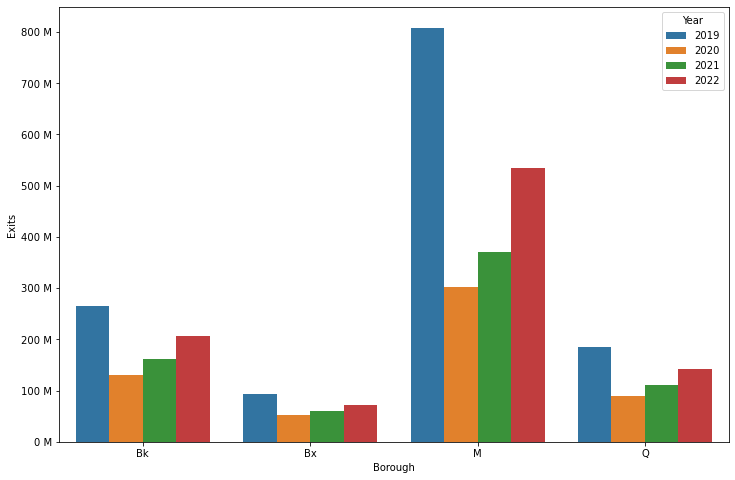

In [25]:
import seaborn as sns
plt.figure(figsize=(12, 8)) # set the size of the figure
ax = sns.barplot(data=boros_allyears, x='Borough', y='Exits', hue='Year')
y_fmt = ticker.FuncFormatter(lambda y, _: '{:.0f} M'.format(y/1000000))
ax.yaxis.set_major_formatter(y_fmt)
plt.savefig('borough_aggregates.png', dpi=300)
plt.show()